In [1]:
cd ..

/home/noahb/fv3net


In [2]:
import xarray as xr
from src.data.advect import *
import os

# Compute the Apparent Sources

This will need to be refactored!

In [3]:
if not os.path.exists("data/interim/apparent_sources.zarr"):

    q1 = apparent_heating(ds.temp, ds.z, ds.w, ds.dtemp).rename("apparent_heating").assign_attrs(units="K/s")
    q2 = apparent_source(ds.qv, ds.z, ds.dqv).rename("apparent_moistening").assign_attrs(units="kg/kg/s")

    xr.Dataset({'q1': q1, 'q2': q2}).to_zarr("data/interim/apparent_sources.zarr")

# Analyze sources

You can use this API to open the complete dataset in the future:

In [4]:
from src.data import open_data
ds = open_data(sources=True)

In [5]:
def plot(x):
    x = x.load()
    x.plot(vmax=x.quantile(.99), yincrease=False)

Zonal averages of the Q1 and Q2:

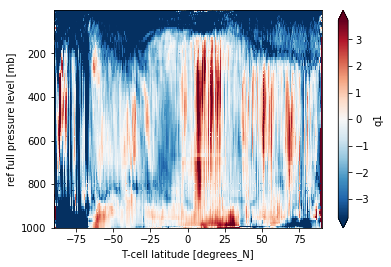

In [6]:
plot(ds.q1.mean(['grid_xt', 'time'])*86400)

There is a large amount of cooling the stratosphere. Why?

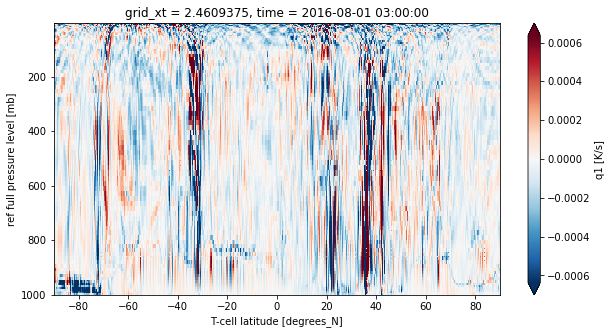

In [7]:
plt.figure(figsize=(10,5))
plot(ds.q1.isel(grid_xt=10, time=0))

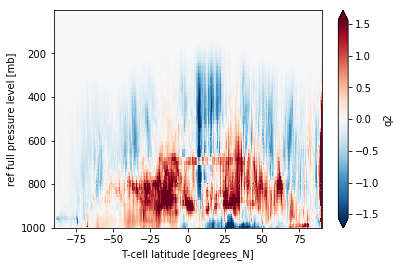

In [8]:
plot(ds.q2.mean(['grid_xt', 'time'])*86400*1000)

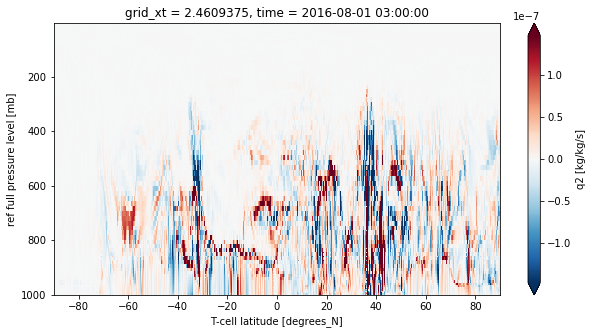

In [9]:
plt.figure(figsize=(10,5))
plot(ds.q2.isel(grid_xt=10, time=0))

# Zonal Average Temperature by term

Q1 has three terms

1. storage $T_t$
2. advection $v.\nabla T$
3. adiabatic: $\frac{g}{c_p} w$

Which of these gives the large stratospheric heating?

In [10]:
avg_dims = ['grid_xt', 'time']

def zonal_average(data):
    return data.mean(avg_dims).persist()


storage = zonal_average(storage_fixed_height(ds.temp, ds.z))
advection = zonal_average(-ds.dtemp)
adiabatic = zonal_average(9.81/1004 * ds.w)

def plot(storage):
    def _(x):
        x = x.load()
        x.plot(vmax=x.quantile(.99), yincrease=False)
    return _(storage*86400)

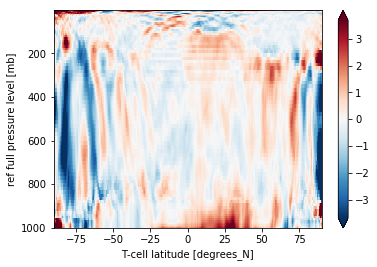

In [11]:
plot(storage)

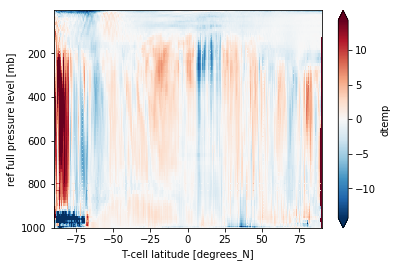

In [12]:
plot(advection)

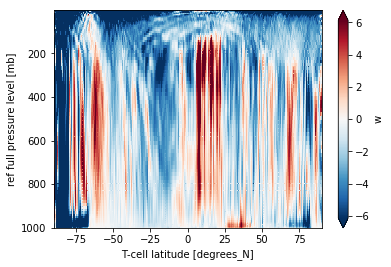

In [13]:
plot(adiabatic)

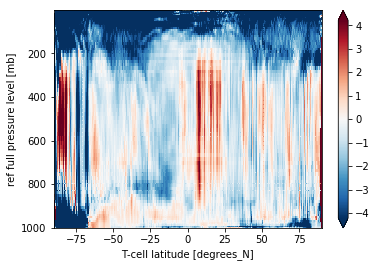

In [14]:
plot(adiabatic+advection)

It appears to mainly come from the adiabatic term. This term should not be negative at all latitudes. This is probably an issue with zonal averaging on model levels. This could be solved by regridding to pressure coordinates.

# compute P-E

In [15]:
ls /home/noahb/data

2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/
2019-08-07_from-2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute.zarr/


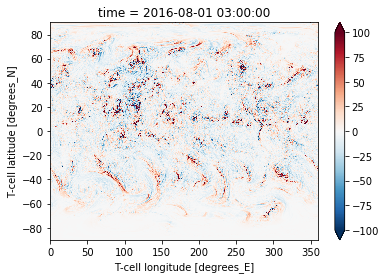

In [16]:
data_2d = xr.open_zarr("/home/noahb/data/2019-07-17-GFDL_FV3_DYAMOND_0.25deg_15minute/2d.zarr")

delp = ds.pres.drop('pfull').differentiate('pfull')

delm = delp/9.81

net_moistening = (delm * ds.q2).sum('pfull').persist()
net_precip = -net_moistening * 86400

net_precip[0].plot(vmax=100)

There are some issues near the pole.

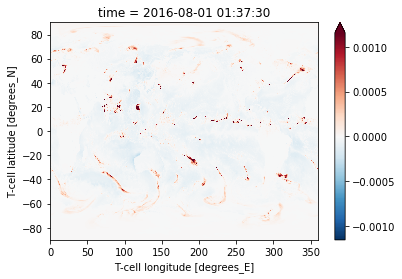

In [17]:
latent_heat_water = 2.51e6
net_prec_true = data_2d.pr - data_2d.lhflx/latent_heat_water
net_prec_3_hourly = net_prec_true.coarsen(time=12).mean()
net_prec_3_hourly[0].plot(vmax=100/86400)
net_prec_3_hourly_mmday = net_prec_3_hourly * 86400

Net precipitation is much cleaner on the 3 hourly time scale.

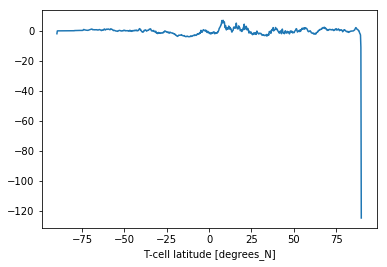

In [18]:
net_precip.mean(['grid_xt', 'time']).plot()

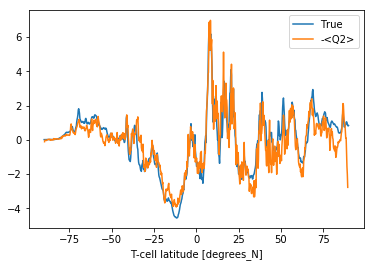

In [19]:
net_prec_3_hourly_mmday.mean(['grid_xt', 'time']).plot(label='True')
net_precip.isel(grid_yt=slice(1,-2)).mean(['grid_xt', 'time']).plot(label='-<Q2>')
plt.legend()

The zonal and time average of the vertical integral of $Q_2$ is close to the truth.